In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import scqubits as qubit
import scqubits.utils.sweep_plotting as splot
from scqubits import HilbertSpace, InteractionTerm, ParameterSweep

import numpy as np
import qutip as qt

# Composite Hilbert Spaces, QuTiP Interface

The `HilbertSpace` class provides data structures and methods for handling composite Hilbert spaces which may consist of multiple qubits or qubits and oscillators coupled to each other. To harness the power of QuTiP, a toolbox for studying stationary and dynamical properties of closed and open quantum systems (and much more), `HilbertSpace` provides a convenient interface: it generates `qutip.qobj` objects which are then directly handled by QuTiP.

## Example: two transmons coupled to a harmonic mode

Transmon qubits can be capacitively coupled to a common harmonic mode, realized by an LC oscillator or a transmission-line resonator. The Hamiltonian describing such a composite system is given by:
\begin{equation}
H=H_\text{tmon,1} + H_\text{tmon,2} + \omega_r a^\dagger a + \sum_{j=1,2}g_j n_j(a+a^\dagger),
\end{equation}
where $j=1,2$ enumerates the two transmon qubits, $\omega_r$ is the (angular) frequency of the resonator. Furthermore, $n_j$ is the charge number operator for qubit $j$, and $g_j$ is the coupling strength between qubit $j$ and the resonator.

### Create Hilbert space components

The first step consists of creating the objects describing the individual building blocks of the full Hilbert space. Here, these will be the two transmons and one oscillator:

In [2]:
tmon1 = qubit.Transmon(
    EJ=40.0,
    EC=0.2,
    ng=0.3,
    ncut=40,
    truncated_dim=4     # after diagonalization, we will keep 3 levels
)

tmon2 = qubit.Transmon(
    EJ=15.0,
    EC=0.15,
    ng=0.0,
    ncut=30,
    truncated_dim=4
)

resonator = qubit.Oscillator(
    omega=4.5,
    truncated_dim=4  # up to 3 photons (0,1,2,3)
)

The system objects are next grouped into a Python list, and in this form used for the initialization of a `HilbertSpace` object. Once created, a print call to this object outputs a summary of the composite Hilbert space.

In [3]:
hilbertspace = qubit.HilbertSpace([tmon1, tmon2, resonator])
print(hilbertspace)

====== HilbertSpace object ======

TRANSMON
 ———— PARAMETERS ————
EJ	: 40.0
EC	: 0.2
ng	: 0.3
ncut	: 40
truncated_dim	: 4
Hilbert space dimension	: 81

TRANSMON
 ———— PARAMETERS ————
EJ	: 15.0
EC	: 0.15
ng	: 0.0
ncut	: 30
truncated_dim	: 4
Hilbert space dimension	: 61

OSCILLATOR
 ———— PARAMETERS ————
omega	: 4.5
truncated_dim	: 4
Hilbert space dimension	: 4



One useful method of the `HilbertSpace` class is `.get_bare_hamiltonian()`. This yields the bare Hamiltonian of the non-interacting subsystems, expressed as a `qutip.Qobj`:

In [4]:
bare_hamiltonian = hilbertspace.get_bare_hamiltonian()
bare_hamiltonian

Quantum object: dims = [[4, 4, 4], [4, 4, 4]], shape = (64, 64), type = oper, isherm = True
Qobj data =
[[-48.96753061   0.           0.         ...   0.           0.
    0.        ]
 [  0.         -44.46753061   0.         ...   0.           0.
    0.        ]
 [  0.           0.         -39.96753061 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...  -9.97661845   0.
    0.        ]
 [  0.           0.           0.         ...   0.          -5.47661845
    0.        ]
 [  0.           0.           0.         ...   0.           0.
   -0.97661845]]

### Set up the interaction between subsystems

The pairwise interactions between subsystems are assumed to have the general form 

$V=\sum_{i\not= j} g_{ij} A_i B_j$, 

where $g_{ij}$ parametrizes the interaction strength between subsystems $i$ and $j$. The operator content of the coupling is given by the two coupling operators $A_i$, $B_j$, which are operators in the two respective subsystems.
This structure is captured by setting up an `InteractionTerm` object:

In [5]:
g1 = 0.1  # coupling resonator-CPB1 (without charge matrix elements)
g2 = 0.2  # coupling resonator-CPB2 (without charge matrix elements)

interaction1 = InteractionTerm(
    hilbertspace = hilbertspace,
    g_strength = g1,
    op1 = tmon1.n_operator(),
    subsys1 = tmon1,
    op2 = resonator.creation_operator() + resonator.annihilation_operator(),
    subsys2 =resonator
)

interaction2 = InteractionTerm(
    hilbertspace = hilbertspace,
    g_strength = g2,
    op1 = tmon2.n_operator(),
    subsys1 = tmon2,
    op2 = resonator.creation_operator() + resonator.annihilation_operator(),
    subsys2 =resonator
)

Each `InteractionTerm` object is initialized by specifying
1. the Hilbert space object to which it will belong
2. the interaction strength coefficient $g_{ij}$
3. `op1`, `op2`: the subsystem operators $A_i$, $B_j$ (these should be operators within the subsystems' respective Hilbert spaces only)
4. `subsys1`: the subsystem objects to which `op1` and `op2` belong



Now, collect all interaction terms in a list, and insert into the HilbertSpace object.

In [6]:
interaction_list = [interaction1, interaction2]
hilbertspace.interaction_list = interaction_list

With the interactions specified, the full Hamiltonian of the coupled system can be obtained via the method `.get_hamiltonian()`. Again, this conveniently results in a `qubit.Qobj` operator:

In [12]:
dressed_hamiltonian = hilbertspace.get_hamiltonian()
dressed_hamiltonian

Quantum object: dims = [[4, 4, 4], [4, 4, 4]], shape = (64, 64), type = oper, isherm = True
Qobj data =
[[-4.89675306e+01  3.00000000e-02  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.00000000e-02 -4.44675306e+01  4.24264069e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  4.24264069e-02 -3.99675306e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -9.97661845e+00
   4.24264070e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.24264070e-02
  -5.47661845e+00  5.19615243e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   5.19615243e-02 -9.76618450e-01]]

### Obtaining the eigenspectrum via QuTiP

Since the Hamiltonian obtained this way is a proper `qutip.qobj`, all QuTiP routines are now available. For instance, here is how to obtain eigenenergies and eigenstates:

In [8]:
evals, evecs = dressed_hamiltonian.eigenstates()
print(evals)

[-48.97770317 -45.02707241 -44.36656205 -41.18438832 -41.1776098
 -40.46448065 -39.76202396 -37.45533167 -37.22705488 -36.65156212
 -36.56694139 -35.88617024 -35.14255357 -33.58960343 -33.38439485
 -33.12061816 -32.66494366 -32.04065582 -31.96284558 -30.93536847
 -29.65538466 -29.63912664 -28.97946785 -28.85287223 -28.64748897
 -28.09427075 -27.35745603 -26.97461415 -26.21586637 -25.79648462
 -25.3216198  -25.07747135 -24.37567532 -24.24760531 -23.66618527
 -23.15199748 -22.2580349  -22.06752989 -21.57303944 -21.26626732
 -20.85288717 -20.51511596 -19.78521899 -19.1938092  -18.41228666
 -17.73463904 -17.66080329 -16.93618597 -16.66699841 -15.89010361
 -15.58181323 -14.68288545 -13.84725844 -13.27037775 -13.08388811
 -12.34366698 -11.62655644 -10.308913    -9.23168892  -8.32791939
  -8.13883089  -5.82301882  -4.18180351  -0.88957289]


## Sweeping over an external parameter

scqubits provides the class `ParameterSweep` to facilitate computation of spectra as function of an external parameter. For efficiency in creating different plots, the computed bare and dressed spectral data are stored internally. A sweep object is initialized as follows.

Suppose both `tmon1` and `tmon2` subsystems are flux-tunable split-junction transmons with different loop areas. 
We consider sweeping a global external flux through the loops. To create the necessary `ParameterSweep` object, we specify:
1. `param_name`: the name of the sweep parameter (below expressed as the flux in units of the flux quantum)
2. `param_vals`: an array with the flux values used in the sweep
3. `subsys_update_list`: a list containing all Hilbert space subsystems that change as the flux is varied
4. `update_hilbertspace(param_val)`: a function that shows how a change in the sweep parameter affects the Hilbert space; here only the `.flux` attributed of the fluxonium qubit needs to be changed

These ingredients all make it into the initialization of the `ParameterSweep` object. Once initialized, spectral data is generated and stored.

In [7]:
param_name = 'flux'                          # name of varying external parameter
param_vals = np.linspace(0.0, 2.0, 300)     # parameter values

subsys_update_list = [tmon1, tmon2]          # list of HilbertSpace subsystems which are affected by parameter changes         

def update_hilbertspace(param_val):          # function that shows how Hilbert space components are updated
    tmon1.EJ = 20*np.abs(np.cos(np.pi * param_val))
    tmon2.EJ = 15*np.abs(np.cos(np.pi * param_val * 0.7))
    
    
sweep = ParameterSweep(
    param_name=param_name,
    param_vals=param_vals,
    evals_count=10,
    hilbertspace=hilbertspace,
    subsys_update_list=subsys_update_list,
    update_hilbertspace=update_hilbertspace,
)

Once the data has been generated, the spectrum can be plotted as a function of the parameter value:

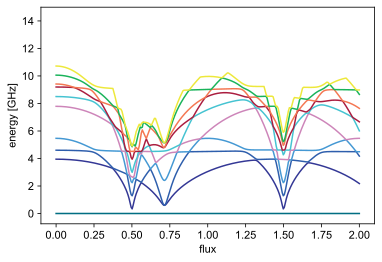

In [8]:
splot.dressed_spectrum(sweep);